In [1]:
%matplotlib inline

In [2]:
import os 
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [5]:
train_features = train_features.astype('float32') / 255.
test_features = test_features.astype('float32') / 255.

In [6]:
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [7]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
parameters = []

In [8]:
nm_epochs = 100
batch_size = 100
num_filters = np.arange(1, 76)
train_num_batches_per_epoch = num_train // batch_size
test_num_batches_per_epoch = num_test // batch_size

x = tf.placeholder('float', [None, img_rows, img_cols, img_channels])
y = tf.placeholder('float', [None, num_classes])
keep_prob = tf.placeholder(tf.float32)

In [9]:
num_filters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75])

In [10]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

In [11]:
def maxpool2d(x):
    #                        size of window         movement of window
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

In [12]:
def neural_network_model(x, num_filter, keep_prob): 
    weights = {'W_conv1':tf.Variable(tf.truncated_normal([3,3,3,num_filter], stddev=0.1)),
               'W_conv2':tf.Variable(tf.truncated_normal([3,3,num_filter,num_filter], stddev=0.1)),                            
               'W_fc':tf.Variable(tf.truncated_normal([8*8*num_filter,512], stddev=0.1)),
               'out':tf.Variable(tf.truncated_normal([512, num_classes], stddev=0.1))}

    biases = {'b_conv1':tf.Variable(tf.constant(0.1, shape=[num_filter])),
               'b_conv2':tf.Variable(tf.constant(0.1, shape=[num_filter])),
               'b_fc':tf.Variable(tf.constant(0.1, shape=[512])),
               'out':tf.Variable(tf.constant(0.1, shape=[num_classes]))}

    conv1 = tf.nn.relu(conv2d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool2d(conv1)
    conv2 = tf.nn.relu(conv2d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool2d(conv2)
    
    fc = tf.reshape(conv2,[-1, 8*8*num_filter])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_prob)

    output = tf.matmul(fc, weights['out'])+biases['out']

    return output

In [13]:
def next_batch(source, target, batch_size):

   # Shuffle data
   shuffle_indices = np.random.permutation(np.arange(len(target)))
   source = source[shuffle_indices]
   target = target[shuffle_indices]

   for batch_i in range(0, len(source)//batch_size):
      start_i = batch_i * batch_size
      source_batch = source[start_i:start_i + batch_size]
      target_batch = target[start_i:start_i + batch_size]

      yield np.array(source_batch), np.array(target_batch)

In [14]:
def train_neural_network(x):
    for num_filter in num_filters:
        max_acc = 0.0
        max_epoch = 0
        prediction = neural_network_model(x, num_filter, keep_prob)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1)), tf.float32))
        optimizer = tf.train.AdamOptimizer().minimize(cost)

        config=tf.ConfigProto()
        config.gpu_options.allow_growth=True
        
        with tf.Session(config=config) as sess:
            sess.run(tf.global_variables_initializer())

            for epoch in range(nm_epochs):
                training_loss = 0.0
                training_acc = 0.0
                testing_loss = 0.0
                testing_acc = 0.0
                for epoch_x, epoch_y in next_batch(train_features, train_labels, batch_size):
                    _, c, a = sess.run([optimizer, cost, accuracy], feed_dict={x: epoch_x, y: epoch_y, keep_prob : 0.8})
                    training_loss += c / train_num_batches_per_epoch
                    training_acc += a / train_num_batches_per_epoch

                for epoch_x, epoch_y in next_batch(test_features, test_labels, batch_size):
                    c, a = sess.run([cost, accuracy], feed_dict={x: epoch_x, y: epoch_y, keep_prob : 1.0})
                    testing_loss += c / test_num_batches_per_epoch
                    testing_acc += a / test_num_batches_per_epoch

                print('Epoch', epoch,'train_loss:',training_loss, 'train_accuracy:', training_acc, 'test_loss:', testing_loss, 'test_accuracy:', testing_acc)

                if testing_acc > max_acc:
                    max_acc = testing_acc
                    max_epoch = epoch
                else:
                    if epoch - max_epoch > 2:
                        break
                
            train_loss.append(training_loss)
            test_loss.append(testing_loss)
            train_acc.append(training_acc)
            test_acc.append(testing_acc)
            parameters.append(np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()]))

In [15]:
train_neural_network(x)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Epoch 0 train_loss: 2.033673427820204 train_accuracy: 0.2546000007539991 test_loss: 1.912849327325821 test_accuracy: 0.307800000756979
Epoch 1 train_loss: 1.8956888794898996 train_accuracy: 0.3093600008785726 test_loss: 1.8520342850685116 test_accuracy: 0.32270000278949745
Epoch 2 train_loss: 1.8327733831405655 train_accuracy: 0.33534000089764604 test_loss: 1.7855502414703368 test_accuracy: 0.3581000003218653
Epoch 3 train_loss: 1.7848157062530532 train_accuracy: 0.35560000035166717 test_loss: 1.7485424053668976 test_accuracy: 0.37399999871850015
Epoch 4 train_loss: 1.7543662316799171 train_accuracy: 0.36740000078082075 test_loss: 1.7205902814865104 test_accuracy: 0.3841999992728233
Epoch 5 train_loss: 1.7321904542446134 train_accuracy: 0.3798999994993209 test_loss: 1.7000865352153784 test_accuracy: 

Epoch 14 train_loss: 1.0676123322248459 train_accuracy: 0.62694000017643 test_loss: 1.2006701153516766 test_accuracy: 0.5801999989151951
Epoch 15 train_loss: 1.0467335714101798 train_accuracy: 0.6358399997949603 test_loss: 1.1950750368833538 test_accuracy: 0.584500000178814
Epoch 16 train_loss: 1.0239405488967894 train_accuracy: 0.6412799999117857 test_loss: 1.1979558324813848 test_accuracy: 0.5852999979257587
Epoch 17 train_loss: 1.0064395035505291 train_accuracy: 0.6493600003719339 test_loss: 1.2005134916305542 test_accuracy: 0.5856999990344047
Epoch 18 train_loss: 0.986717692017555 train_accuracy: 0.6562799992561351 test_loss: 1.1978507661819453 test_accuracy: 0.590999999344349
Epoch 19 train_loss: 0.9667560043334964 train_accuracy: 0.6625600000619887 test_loss: 1.2056339150667197 test_accuracy: 0.5855999964475631
Epoch 20 train_loss: 0.9463933374881746 train_accuracy: 0.6686400015354168 test_loss: 1.1988218849897385 test_accuracy: 0.5875000005960465
Epoch 21 train_loss: 0.933842458

Epoch 8 train_loss: 0.9892591915130614 train_accuracy: 0.6530200003385548 test_loss: 1.0862415981292721 test_accuracy: 0.6133999976515772
Epoch 9 train_loss: 0.9516471538543707 train_accuracy: 0.6674200004339226 test_loss: 1.0779934459924696 test_accuracy: 0.6245000013709068
Epoch 10 train_loss: 0.9080043910741805 train_accuracy: 0.6833799993991849 test_loss: 1.0659630239009856 test_accuracy: 0.6271999979019165
Epoch 11 train_loss: 0.8743099210262294 train_accuracy: 0.6957800019979482 test_loss: 1.0472144138813018 test_accuracy: 0.631800000369549
Epoch 12 train_loss: 0.8405092864036562 train_accuracy: 0.7068200024366371 test_loss: 1.0720263963937762 test_accuracy: 0.6247000014781955
Epoch 13 train_loss: 0.803247551083565 train_accuracy: 0.7194800010919561 test_loss: 1.050113312602043 test_accuracy: 0.6363000029325486
Epoch 14 train_loss: 0.7769977608919141 train_accuracy: 0.7285000019073475 test_loss: 1.0436464047431944 test_accuracy: 0.6374000024795534
Epoch 15 train_loss: 0.744510214

Epoch 8 train_loss: 0.8394762665033343 train_accuracy: 0.7057400019168856 test_loss: 0.9827586352825165 test_accuracy: 0.653399998545647
Epoch 9 train_loss: 0.7819662809371947 train_accuracy: 0.7270800018310535 test_loss: 0.9725154978036885 test_accuracy: 0.6626000010967256
Epoch 10 train_loss: 0.7342748070955282 train_accuracy: 0.7453399995565408 test_loss: 0.9874618780612946 test_accuracy: 0.6651999998092653
Epoch 11 train_loss: 0.6919202982783317 train_accuracy: 0.7587599997520437 test_loss: 0.9818234080076219 test_accuracy: 0.6626000022888188
Epoch 12 train_loss: 0.6418363843560223 train_accuracy: 0.777099998831748 test_loss: 0.9979909247159958 test_accuracy: 0.6593000036478038
Epoch 13 train_loss: 0.5933246448040017 train_accuracy: 0.7927399983406057 test_loss: 0.998821613788605 test_accuracy: 0.6665000033378602
Epoch 14 train_loss: 0.5592926746010779 train_accuracy: 0.8047599985599506 test_loss: 1.0129917716979984 test_accuracy: 0.6700999993085864
Epoch 15 train_loss: 0.517410605

Epoch 13 train_loss: 0.4823014403581622 train_accuracy: 0.8305399988889686 test_loss: 1.0543119859695436 test_accuracy: 0.6673000013828276
Epoch 14 train_loss: 0.43353729251027096 train_accuracy: 0.848239998936652 test_loss: 1.073181856870651 test_accuracy: 0.6792000025510786
Epoch 15 train_loss: 0.3977779855430123 train_accuracy: 0.8609999997615809 test_loss: 1.1055480271577836 test_accuracy: 0.6779000037908557
Epoch 16 train_loss: 0.3585118333399294 train_accuracy: 0.8751200004816058 test_loss: 1.116277012228966 test_accuracy: 0.6750999987125398
Epoch 17 train_loss: 0.33106239250302333 train_accuracy: 0.8839799998998651 test_loss: 1.1476583164930347 test_accuracy: 0.6773999989032752
Epoch 0 train_loss: 1.6555870366096477 train_accuracy: 0.406819997757673 test_loss: 1.39719443321228 test_accuracy: 0.49169999599456793
Epoch 1 train_loss: 1.296859543204307 train_accuracy: 0.537499997556209 test_loss: 1.176810432076455 test_accuracy: 0.5836000001430512
Epoch 2 train_loss: 1.1488051556348

Epoch 9 train_loss: 0.5586133936047554 train_accuracy: 0.8060399971008275 test_loss: 0.9104943317174911 test_accuracy: 0.701999999880791
Epoch 10 train_loss: 0.4996026926040652 train_accuracy: 0.8262599976062761 test_loss: 0.8971968841552738 test_accuracy: 0.7045000016689301
Epoch 11 train_loss: 0.4494366362094875 train_accuracy: 0.8433599973916989 test_loss: 0.9430431813001632 test_accuracy: 0.7007999998331073
Epoch 12 train_loss: 0.39934563335776385 train_accuracy: 0.8603999991416923 test_loss: 0.9475870013236999 test_accuracy: 0.7054000014066699
Epoch 13 train_loss: 0.36021610137820265 train_accuracy: 0.8748799996376035 test_loss: 0.9914773923158646 test_accuracy: 0.706200003027916
Epoch 14 train_loss: 0.3137699143886567 train_accuracy: 0.8909400011301052 test_loss: 1.0304476672410972 test_accuracy: 0.698900002837181
Epoch 15 train_loss: 0.28545208527147786 train_accuracy: 0.9019400008916859 test_loss: 1.063559849858284 test_accuracy: 0.7058000028133392
Epoch 16 train_loss: 0.251372

Epoch 16 train_loss: 0.22024672940373435 train_accuracy: 0.9233800023794168 test_loss: 1.19597944021225 test_accuracy: 0.6939000052213674
Epoch 0 train_loss: 1.5637015695571892 train_accuracy: 0.43877999824285446 test_loss: 1.3063841843605044 test_accuracy: 0.5321999976038932
Epoch 1 train_loss: 1.1868024780750281 train_accuracy: 0.5794999989271165 test_loss: 1.1075537705421443 test_accuracy: 0.6056999987363815
Epoch 2 train_loss: 1.0281644366979596 train_accuracy: 0.6350800005197533 test_loss: 1.0008281892538071 test_accuracy: 0.6475999993085862
Epoch 3 train_loss: 0.9213677784204483 train_accuracy: 0.6764800007343293 test_loss: 0.9463922429084777 test_accuracy: 0.6697000020742416
Epoch 4 train_loss: 0.8287354658842083 train_accuracy: 0.7080800026655195 test_loss: 0.922026404738426 test_accuracy: 0.6846999996900559
Epoch 5 train_loss: 0.7487035700082783 train_accuracy: 0.7372800016403187 test_loss: 0.8913320714235308 test_accuracy: 0.690700001716614
Epoch 6 train_loss: 0.6712880656719

Epoch 6 train_loss: 0.6276688139438626 train_accuracy: 0.7833599997758857 test_loss: 0.8599602645635602 test_accuracy: 0.7105000019073487
Epoch 7 train_loss: 0.5486561665534975 train_accuracy: 0.8100399980545039 test_loss: 0.8929562222957612 test_accuracy: 0.7031000030040743
Epoch 8 train_loss: 0.4738535403013231 train_accuracy: 0.8342399976253492 test_loss: 0.8774989885091784 test_accuracy: 0.711500002741814
Epoch 9 train_loss: 0.405912017047405 train_accuracy: 0.8597799990177153 test_loss: 0.9361068743467336 test_accuracy: 0.7091000026464466
Epoch 10 train_loss: 0.34863122537732155 train_accuracy: 0.8796799994707114 test_loss: 0.9532373887300487 test_accuracy: 0.7096000027656553
Epoch 11 train_loss: 0.29277712151408175 train_accuracy: 0.8985600010156637 test_loss: 1.04286478638649 test_accuracy: 0.7082000017166137
Epoch 0 train_loss: 1.4925805938243892 train_accuracy: 0.4642999978810548 test_loss: 1.2457096993923196 test_accuracy: 0.557799996435642
Epoch 1 train_loss: 1.1399679406881

Epoch 2 train_loss: 1.017337378382683 train_accuracy: 0.6447600009441382 test_loss: 0.9682854712009428 test_accuracy: 0.6607000005245213
Epoch 3 train_loss: 0.8986176762580869 train_accuracy: 0.6840000014305115 test_loss: 0.9644756758213042 test_accuracy: 0.6593000006675721
Epoch 4 train_loss: 0.7854299058914177 train_accuracy: 0.7245200004577628 test_loss: 0.9255621385574341 test_accuracy: 0.6798000019788746
Epoch 5 train_loss: 0.6831990745067598 train_accuracy: 0.7625399993658051 test_loss: 0.9047398567199707 test_accuracy: 0.691600000858307
Epoch 6 train_loss: 0.5882811409831044 train_accuracy: 0.7943799986839283 test_loss: 0.8802459263801573 test_accuracy: 0.7070000028610229
Epoch 7 train_loss: 0.49897841721773123 train_accuracy: 0.8258199967145899 test_loss: 0.9081076246500015 test_accuracy: 0.7062000006437303
Epoch 8 train_loss: 0.4199618844389917 train_accuracy: 0.8533199993371948 test_loss: 0.9468240052461627 test_accuracy: 0.6990000033378603
Epoch 9 train_loss: 0.3524978468716

Epoch 12 train_loss: 0.173829387769103 train_accuracy: 0.9426000019311912 test_loss: 1.206397424340248 test_accuracy: 0.7040000021457673
Epoch 13 train_loss: 0.15261446237564094 train_accuracy: 0.9489200006723438 test_loss: 1.2877103936672205 test_accuracy: 0.6993000024557116
Epoch 14 train_loss: 0.1306405070424079 train_accuracy: 0.9558800032138856 test_loss: 1.3761273658275612 test_accuracy: 0.6916000020504001
Epoch 0 train_loss: 1.5865953443050373 train_accuracy: 0.4325399987101553 test_loss: 1.2566234791278839 test_accuracy: 0.5544999974966051
Epoch 1 train_loss: 1.185401185035705 train_accuracy: 0.5797199986577036 test_loss: 1.100824186205864 test_accuracy: 0.607700001001358
Epoch 2 train_loss: 1.0117122404575347 train_accuracy: 0.6463600004911434 test_loss: 0.9883036839962009 test_accuracy: 0.6535000002384187
Epoch 3 train_loss: 0.8784318592548375 train_accuracy: 0.69514000236988 test_loss: 0.9327649933099748 test_accuracy: 0.6746999996900559
Epoch 4 train_loss: 0.758816358387470

Epoch 14 train_loss: 0.12512630124390126 train_accuracy: 0.9576200027465863 test_loss: 1.280508714914322 test_accuracy: 0.7164000010490418
Epoch 15 train_loss: 0.11484195078536878 train_accuracy: 0.9617400046587037 test_loss: 1.3362781614065176 test_accuracy: 0.7069000017642976
Epoch 16 train_loss: 0.09817029048129919 train_accuracy: 0.9671800055503894 test_loss: 1.3966879886388779 test_accuracy: 0.7183000022172933
Epoch 17 train_loss: 0.09924239908158777 train_accuracy: 0.9658400061130573 test_loss: 1.379003999829292 test_accuracy: 0.7145999997854231
Epoch 18 train_loss: 0.08736031465418642 train_accuracy: 0.9706800076961581 test_loss: 1.452426253557205 test_accuracy: 0.7162000018358229
Epoch 19 train_loss: 0.08714048735052342 train_accuracy: 0.9705800073146871 test_loss: 1.5077425444126127 test_accuracy: 0.7155000013113024
Epoch 0 train_loss: 1.5887935690879817 train_accuracy: 0.4374199974015351 test_loss: 1.2599689412117003 test_accuracy: 0.5515999999642374
Epoch 1 train_loss: 1.173

Epoch 0 train_loss: 1.5857369401454937 train_accuracy: 0.44509999780356857 test_loss: 1.2219885706901557 test_accuracy: 0.5672999987006186
Epoch 1 train_loss: 1.1371565941572184 train_accuracy: 0.5990600000619888 test_loss: 1.0323083883523945 test_accuracy: 0.6295000019669531
Epoch 2 train_loss: 0.9575261896848687 train_accuracy: 0.6621200022697451 test_loss: 0.9580039513111114 test_accuracy: 0.6611000019311908
Epoch 3 train_loss: 0.8301336648464205 train_accuracy: 0.7081000008583064 test_loss: 0.9199352079629896 test_accuracy: 0.6785000014305116
Epoch 4 train_loss: 0.7098046226501463 train_accuracy: 0.7508199994564044 test_loss: 0.8732622283697127 test_accuracy: 0.696100002527237
Epoch 5 train_loss: 0.6063587292432779 train_accuracy: 0.7883599975109087 test_loss: 0.8451979732513429 test_accuracy: 0.713800002336502
Epoch 6 train_loss: 0.4991783378124234 train_accuracy: 0.8258800003528584 test_loss: 0.8539500993490221 test_accuracy: 0.7153000015020372
Epoch 7 train_loss: 0.3962164623439

Epoch 12 train_loss: 0.1373449398577213 train_accuracy: 0.9540800024271048 test_loss: 1.2228694486618046 test_accuracy: 0.716300001144409
Epoch 13 train_loss: 0.11439374844729903 train_accuracy: 0.9614800033569386 test_loss: 1.3190879064798364 test_accuracy: 0.7124000000953674
Epoch 14 train_loss: 0.11123600341752185 train_accuracy: 0.9629800047874499 test_loss: 1.3170457935333257 test_accuracy: 0.7122000014781951
Epoch 0 train_loss: 1.558158521890641 train_accuracy: 0.45149999802559593 test_loss: 1.2667532575130465 test_accuracy: 0.53939999550581
Epoch 1 train_loss: 1.1454700695276265 train_accuracy: 0.5952399996519094 test_loss: 1.06249498963356 test_accuracy: 0.6197000008821487
Epoch 2 train_loss: 0.9805153517723089 train_accuracy: 0.6552400012016302 test_loss: 0.972884733080864 test_accuracy: 0.6599000030755997
Epoch 3 train_loss: 0.8520832127332693 train_accuracy: 0.7047200021743774 test_loss: 0.9089338970184326 test_accuracy: 0.6817000037431716
Epoch 4 train_loss: 0.7406380198001

Epoch 9 train_loss: 0.25749207235872723 train_accuracy: 0.9107600007057188 test_loss: 1.0220460087060925 test_accuracy: 0.711700000166893
Epoch 10 train_loss: 0.2081381032019854 train_accuracy: 0.9286600013971326 test_loss: 1.1028521108627318 test_accuracy: 0.7028000032901767
Epoch 0 train_loss: 1.5836912128925318 train_accuracy: 0.44495999758690546 test_loss: 1.2432752990722662 test_accuracy: 0.5622999969124794
Epoch 1 train_loss: 1.1651481935977932 train_accuracy: 0.5858799978494651 test_loss: 1.0721949267387392 test_accuracy: 0.620899998545647
Epoch 2 train_loss: 0.9957562355995173 train_accuracy: 0.6494400004148488 test_loss: 0.9758491230010983 test_accuracy: 0.6525000017881394
Epoch 3 train_loss: 0.8612068723440175 train_accuracy: 0.6981200017929077 test_loss: 0.9292810463905335 test_accuracy: 0.674800002574921
Epoch 4 train_loss: 0.7421030487418178 train_accuracy: 0.7409400014877311 test_loss: 0.8731414192914964 test_accuracy: 0.6973000049591065
Epoch 5 train_loss: 0.636468984186

Epoch 4 train_loss: 0.7761939646005633 train_accuracy: 0.7293400007486338 test_loss: 0.8769542640447614 test_accuracy: 0.694299998879433
Epoch 5 train_loss: 0.6583315032720565 train_accuracy: 0.7700999991893757 test_loss: 0.8880950540304187 test_accuracy: 0.698100004196167
Epoch 6 train_loss: 0.5580051450729366 train_accuracy: 0.8051999980211252 test_loss: 0.9068108004331588 test_accuracy: 0.6970000040531157
Epoch 7 train_loss: 0.4597880972027778 train_accuracy: 0.8415999985933297 test_loss: 0.8926181906461719 test_accuracy: 0.7160000002384183
Epoch 8 train_loss: 0.3661309953629973 train_accuracy: 0.8699400018453612 test_loss: 0.9170094978809356 test_accuracy: 0.7191000020504
Epoch 9 train_loss: 0.2861449920684098 train_accuracy: 0.9006800016164781 test_loss: 0.9654291582107546 test_accuracy: 0.7219000035524368
Epoch 10 train_loss: 0.22855285455286523 train_accuracy: 0.9211600018739691 test_loss: 1.056380756497383 test_accuracy: 0.7170000028610232
Epoch 11 train_loss: 0.186058406263589

Epoch 10 train_loss: 0.18249011397361756 train_accuracy: 0.938320000171662 test_loss: 1.1207473564147952 test_accuracy: 0.7144000029563902
Epoch 11 train_loss: 0.1526035620048643 train_accuracy: 0.9475200018882782 test_loss: 1.2038348811864854 test_accuracy: 0.7116000026464465
Epoch 12 train_loss: 0.1233752164095641 train_accuracy: 0.9588600043058427 test_loss: 1.2612856632471083 test_accuracy: 0.7064000034332277
Epoch 13 train_loss: 0.11413271411508337 train_accuracy: 0.9625800050497104 test_loss: 1.3236595058441163 test_accuracy: 0.7129000020027161
Epoch 0 train_loss: 1.6388849871158617 train_accuracy: 0.4390399977937334 test_loss: 1.2133534973859785 test_accuracy: 0.5650999957323074
Epoch 1 train_loss: 1.143302678823472 train_accuracy: 0.5938799986839297 test_loss: 1.0859319102764131 test_accuracy: 0.6091999977827072
Epoch 2 train_loss: 0.9549137492179872 train_accuracy: 0.6629200015068061 test_loss: 0.9543968474864959 test_accuracy: 0.6612000030279159
Epoch 3 train_loss: 0.81603365

Epoch 5 train_loss: 0.5916577956080437 train_accuracy: 0.7920399975776662 test_loss: 0.860998246669769 test_accuracy: 0.7083999997377397
Epoch 6 train_loss: 0.48547466135025025 train_accuracy: 0.8288999984264362 test_loss: 0.903055250644684 test_accuracy: 0.7041999995708464
Epoch 7 train_loss: 0.3828106413185597 train_accuracy: 0.8672800000905988 test_loss: 0.947100368142128 test_accuracy: 0.7080000013113021
Epoch 8 train_loss: 0.3013838116824629 train_accuracy: 0.8961600022315988 test_loss: 0.9925207316875457 test_accuracy: 0.7132000023126601
Epoch 9 train_loss: 0.2350024733543394 train_accuracy: 0.9199200024604798 test_loss: 1.0789624863862992 test_accuracy: 0.7049000036716456
Epoch 10 train_loss: 0.19366794385015978 train_accuracy: 0.9323800013065336 test_loss: 1.1021274405717851 test_accuracy: 0.7166000026464466
Epoch 11 train_loss: 0.15995769536495216 train_accuracy: 0.9454200016260162 test_loss: 1.2039068603515628 test_accuracy: 0.7059000015258791
Epoch 12 train_loss: 0.134460315

Epoch 5 train_loss: 0.6622763914465908 train_accuracy: 0.7692599992752059 test_loss: 0.8779652911424636 test_accuracy: 0.6999999994039536
Epoch 6 train_loss: 0.5541117981672284 train_accuracy: 0.808139997839926 test_loss: 0.870711679458618 test_accuracy: 0.7127000021934506
Epoch 7 train_loss: 0.4536068581342695 train_accuracy: 0.84307999908924 test_loss: 0.8791165363788602 test_accuracy: 0.7161000025272369
Epoch 8 train_loss: 0.3599830298125744 train_accuracy: 0.8734199992418298 test_loss: 0.942914415001869 test_accuracy: 0.7087999993562698
Epoch 9 train_loss: 0.2870419696122409 train_accuracy: 0.9012800019979471 test_loss: 1.0028505289554592 test_accuracy: 0.7121000027656554
Epoch 10 train_loss: 0.22714693129062666 train_accuracy: 0.922180000662804 test_loss: 1.0651436370611194 test_accuracy: 0.7152000033855435
Epoch 0 train_loss: 1.578367626428604 train_accuracy: 0.4521199983805415 test_loss: 1.2213243812322618 test_accuracy: 0.5681999963521956
Epoch 1 train_loss: 1.1155070891380299 

Epoch 0 train_loss: 1.62440545296669 train_accuracy: 0.43843999791890337 test_loss: 1.2770875930786136 test_accuracy: 0.5477999988198281
Epoch 1 train_loss: 1.1791880453824994 train_accuracy: 0.5780599980950354 test_loss: 1.0893618148565294 test_accuracy: 0.6124999976158143
Epoch 2 train_loss: 0.9955801899433138 train_accuracy: 0.6490400011539461 test_loss: 0.9783708357810973 test_accuracy: 0.6555000007152555
Epoch 3 train_loss: 0.8413716473579399 train_accuracy: 0.7045800017118449 test_loss: 0.9139087116718293 test_accuracy: 0.6798000019788745
Epoch 4 train_loss: 0.7197770899534226 train_accuracy: 0.7482599990367876 test_loss: 0.8847257554531097 test_accuracy: 0.6922999989986423
Epoch 5 train_loss: 0.5960631844997409 train_accuracy: 0.7884999990463246 test_loss: 0.8725891554355621 test_accuracy: 0.7086999982595444
Epoch 6 train_loss: 0.4824835103154185 train_accuracy: 0.8284399986267081 test_loss: 0.9291040223836902 test_accuracy: 0.6988000029325483
Epoch 7 train_loss: 0.3854540208876

In [16]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(3, 3, 3, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(64, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_4:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Variable_5:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'Variable_6:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'Variable_7:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(3, 3, 3, 2) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(3, 3, 2, 2) dtype=float32_ref>,
 <tf.Variable 'Variable_10:0' shape=(128, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_11:0' shape=(512, 10) dtype=float32_ref>,
 <tf.Variable 'Variable_12:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'Variable_13:0' shape=(2,) dtype=float32_ref>,
 <tf.Variable 'Variable_14:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'Variable_15:0' shape=(10

In [17]:
parameters = np.concatenate([[parameters[0]], np.diff(parameters)], axis=0)

In [18]:
parameters

array([  38448,   71272,  104114,  136974,  169852,  202748,  235662,
        268594,  301544,  334512,  367498,  400502,  433524,  466564,
        499622,  532698,  565792,  598904,  632034,  665182,  698348,
        731532,  764734,  797954,  831192,  864448,  897722,  931014,
        964324,  997652, 1030998, 1064362, 1097744, 1131144, 1164562,
       1197998, 1231452, 1264924, 1298414, 1331922, 1365448, 1398992,
       1432554, 1466134, 1499732, 1533348, 1566982, 1600634, 1634304,
       1667992, 1701698, 1735422, 1769164, 1802924, 1836702, 1870498,
       1904312, 1938144, 1971994, 2005862, 2039748, 2073652, 2107574,
       2141514, 2175472, 2209448, 2243442, 2277454, 2311484, 2345532,
       2379598, 2413682, 2447784, 2481904, 2516042])

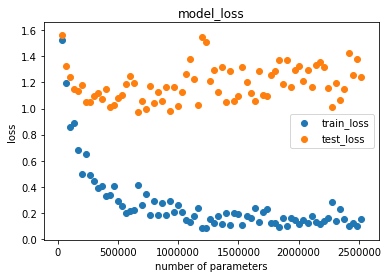

In [22]:
#plt.figure()
plt.scatter(parameters, train_loss, label="train_loss")
plt.scatter(parameters, test_loss, label="test_loss")
plt.xlabel('number of parameters')
plt.ylabel('loss')
plt.title('model_loss')
plt.legend(loc='best')
#plt.savefig("loss.png")
plt.show()

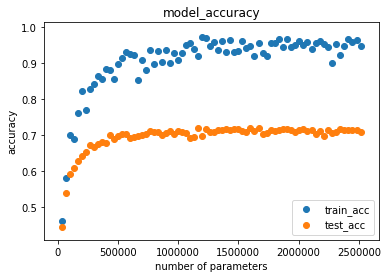

In [23]:
#plt.figure()
plt.scatter(parameters, train_acc, label="train_acc")
plt.scatter(parameters, test_acc, label="test_acc")
plt.xlabel('number of parameters')
plt.ylabel('accuracy')
plt.title('model_accuracy')
plt.legend(loc='best')
#plt.savefig("acc.png")
plt.show()